# Aggregate No. of G@C Collection Points & G@C Recycling Volume

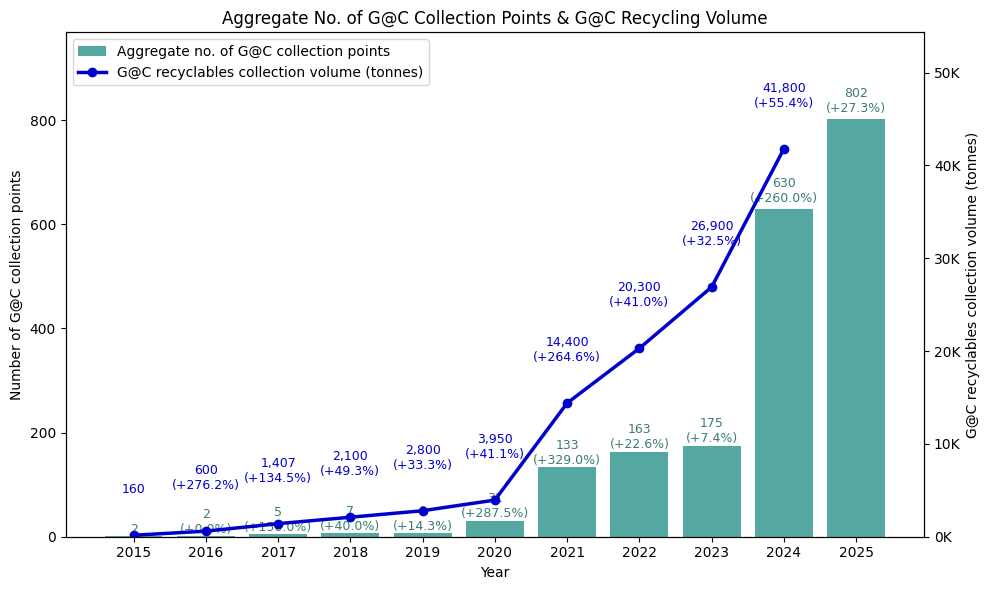

In [5]:
# ==== Install required packages (run these in a terminal, not inside Python) ====
# pip install pandas matplotlib openpyxl

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path
import math
import numpy as np

# -------------------------------------------------------
# 1. Load data from the Excel file
# -------------------------------------------------------
excel_path = "../General Stats_G@C_clean.xlsx"

hk = pd.read_excel(
    excel_path,
    sheet_name="HK MSW Volume and Recycling Rat"
)

# -------------------------------------------------------
# 2. Prepare the relevant data
#    - points: years with collection points (2015–2025)
#    - volume: years with volume (2015–2024)
# -------------------------------------------------------
col_year    = "Year"
col_points  = "Number of G@C collection points"
col_volume  = "G@C recyclables collection volume (tonnes)"

# --- points data (allow missing volume) ---
points_df = hk[[col_year, col_points]].copy()
points_df = points_df[points_df[col_year].notna() & points_df[col_points].notna()].copy()
points_df["Year_int"] = points_df[col_year].astype(int)
points_df["points"]   = pd.to_numeric(points_df[col_points], errors="coerce")
points_df = points_df.sort_values("Year_int")

years_points = points_df["Year_int"].tolist()
points       = points_df["points"].tolist()

# year-on-year % change for points
points_pct_change = points_df["points"].pct_change() * 100
points_pct_map = dict(zip(points_df["Year_int"], points_pct_change))

# --- volume data (may stop at 2024) ---
vol_df = hk[[col_year, col_volume]].copy()
vol_df = vol_df[vol_df[col_year].notna() & vol_df[col_volume].notna()].copy()
vol_df["Year_int"]   = vol_df[col_year].astype(int)
vol_df["vol_tonnes"] = (
    vol_df[col_volume]
    .astype(str)
    .str.replace(",", "", regex=False)
    .astype(float)
)
vol_df = vol_df.sort_values("Year_int")

vol_map     = dict(zip(vol_df["Year_int"], vol_df["vol_tonnes"]))
vol_pct_map = dict(zip(
    vol_df["Year_int"],
    vol_df["vol_tonnes"].pct_change() * 100
))

# build volume series aligned with ALL point years (2015–2025)
volumes_aligned    = [vol_map.get(y, float("nan")) for y in years_points]
vol_pct_aligned    = [vol_pct_map.get(y, float("nan")) for y in years_points]

# -------------------------------------------------------
# 3. Plot: teal bars (points) + light-green line (volume)
# -------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(10, 6))

x = range(len(years_points))

# --- Left axis: aggregate no. of collection points (bars) ---
bars = ax1.bar(
    x,
    points,
    color="#55a8a2",   # teal
    label="Aggregate no. of G@C collection points",
)

ax1.set_xlabel("Year")
ax1.set_ylabel("Number of G@C collection points")

ax1.set_xticks(list(x))
ax1.set_xticklabels([str(y) for y in years_points], rotation=0)

# Bar labels: value\n(% change)
for xi, bar, val, year in zip(x, bars, points, years_points):
    pct = points_pct_map.get(year, float("nan"))
    value_text = f"{val:.0f}"
    if math.isnan(pct):
        label = value_text
    else:
        label = f"{value_text}\n({pct:+.1f}%)"
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() * 1.01,
        label,
        ha="center",
        va="bottom",
        fontsize=9,
        color="#3b7c77",
    )

# extra headroom so bar labels aren’t cut off
y1_min, y1_max = ax1.get_ylim()
ax1.set_ylim(y1_min, y1_max * 1.15)

# --- Right axis: G@C recycling volume (line) ---
ax2 = ax1.twinx()

def k_formatter(val, pos):
    return f"{int(val/1000):,}K"

ax2.yaxis.set_major_formatter(FuncFormatter(k_formatter))

line_vol, = ax2.plot(
    x,
    volumes_aligned,          # NaN for 2025 -> no point / segment
    color="#0000CD",          # light green
    marker="o",
    linewidth=2.5,
    label="G@C recyclables collection volume (tonnes)",
)

ax2.set_ylabel("G@C recyclables collection volume (tonnes)")

# use max of non-NaN volumes for axis + offsets
vol_max = np.nanmax(volumes_aligned) if volumes_aligned else 0
if vol_max <= 0 or math.isnan(vol_max):
    vol_max = 1
ax2.set_ylim(0, vol_max * 1.30)

# Line labels: value\n(% change) – skip NaN (e.g. 2025)
vol_offset = vol_max * 0.1
for xi, v, year in zip(x, volumes_aligned, years_points):
    if math.isnan(v):
        continue   # no line / label for years without volume (e.g. 2025)
    pct = vol_pct_map.get(year, float("nan"))
    value_text = f"{v:,.0f}"
    if math.isnan(pct):
        label = value_text
    else:
        label = f"{value_text}\n({pct:+.1f}%)"
    ax2.text(
        xi,
        v + vol_offset,
        label,
        ha="center",
        va="bottom",
        fontsize=9,
        color="#0000CD",
    )

# -------------------------------------------------------
# 4. Legend, title, layout
# -------------------------------------------------------
handles = [bars, line_vol]
labels  = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc="upper left")

plt.title("Aggregate No. of G@C Collection Points & G@C Recycling Volume")
plt.tight_layout()
plt.show()
